In [1]:
# load useful libraries
import os
import wfdb as wf
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from biosppy.signals import ecg
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
import glob
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Input, Convolution1D, GlobalMaxPool1D, \
    concatenate
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


In [2]:
# Load data from 'AllData_to_norm.csv'. This file contains 500 of each of these type of signals: ECG, EMG, and EEG labeled as 1, 2 and 3 respectively.
# Each row represents a 10 second sample, resampled to 1000 adquisitions per second. 
# In terms of this sequential data machine learning algorithm, each sample has 10000 features.

data=pd.read_csv('AllData_to_norm.csv', header=None) 


In [3]:
# check for nan values
data_clean=data.dropna(axis=0)
# 2 out of 1500 samples were dropped

In [4]:
# set X (training data) and y (target variable)
cols = data_clean.shape[1]
features = data_clean.iloc[:,0:cols-1]
target = data_clean.iloc[:,cols-1:cols]
data_clean


,0,1,2,3,4,5,6,7,8,9,...,9992,9993,9994,9995,9996,9997,9998,9999,10000,10001
0,810.00,811.532876,810.00,808.467124,810.00,814.598628,810.00,786.388365,756.00,732.347912,...,-176.00,-186.285922,-200.00,-202.696359,-195.00,-181.303641,-166.00,-153.481796,-148.141748,1
1,527.00,527.292872,527.00,526.707128,527.00,527.878615,527.00,522.528412,517.00,512.882735,...,122.00,113.124255,102.00,94.583582,93.00,98.416418,112.00,134.917908,168.337306,1
2,49.00,41.501907,34.00,30.248093,34.00,46.505720,59.00,63.229025,63.00,63.453178,...,-20.00,-20.963976,-20.00,-21.137008,-24.00,-27.112992,-29.00,-28.185040,-23.192128,1
3,0.00,-9.874520,-15.00,-15.125480,-10.00,-0.248560,10.00,16.744718,20.00,20.769686,...,5.00,4.687185,5.00,3.229272,0.00,-3.229272,-5.00,-3.853641,1.668348,1
4,273.00,273.370362,273.00,272.629638,273.00,274.111086,273.00,267.176017,259.00,251.309845,...,-5.00,2.913658,10.00,11.737114,10.00,8.262886,10.00,18.685570,37.793823,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,6.59,-1.130000,-7.17,-5.640000,-1.48,0.510000,5.51,5.800000,0.50,0.440000,...,-7.81,-6.700000,-5.44,-7.550000,-9.75,-9.040000,-5.41,-7.170000,-7.800000,3
1496,-7.80,-5.600000,-4.96,-7.210000,-5.68,-5.840000,-6.40,-6.740000,-3.92,-4.290000,...,-4.16,-3.010000,-2.65,-2.650000,-4.93,-3.630000,-2.36,-2.600000,-2.940000,3
1497,-4.09,-4.070000,-2.83,-5.520000,-2.79,-2.360000,-2.55,-2.690000,-1.02,-1.890000,...,-0.17,-2.470000,-3.14,-2.040000,-0.82,-1.220000,0.14,-1.760000,-1.180000,3
1498,-0.84,0.820000,-2.29,-0.640000,0.31,2.860000,1.93,-0.040000,1.59,-1.220000,...,-0.95,-0.530000,1.37,1.050000,0.04,0.350000,3.26,-0.690000,1.300000,3


In [5]:
# normalize each sample from 0 to 1
features_norm = normalize(features, norm='l2', axis=1)

In [6]:
# create df with normalized samples
features_ready=pd.DataFrame(features_norm)

In [7]:
# sanity check for features and target shape
print(features_ready.shape, target.shape)

(1498, 10001) (1498, 1)


In [8]:
# convert X and Y from pandas to np
X = np.matrix(features_ready.values)
Y = np.matrix(target.values)

# sanity check
print(Y.shape)


(1498, 1)


In [9]:
# split the data into "training" and "test" datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state =42)

In [10]:
print(Y.shape)

(1498, 1)


In [11]:
# Sanity check, labels should start from 0 to n, otherwise the softmax function gets confused
np.unique(Y_train, axis=0)


array([[1],
       [2],
       [3]], dtype=int64)

In [12]:
# Converting my labels to 0,1,2 instead of 1,2,3
Y_train_fix = Y_train-1
Y_test_fix = Y_test-1

# Sanity check for Y_train_fix 
np.unique(Y_train_fix, axis=0)


array([[0],
       [1],
       [2]], dtype=int64)

In [13]:
# Sanity check for Y_test_fix 
np.unique(Y_test_fix, axis=0)


array([[0],
       [1],
       [2]], dtype=int64)

In [14]:
# defining the classifier
def EMGEEGECG_classifier():
    # defining input shape of each sample
    inp = Input(shape=(10001, 1))
    # using a convoluted 1D layer with 32 filters, and kernel size=5, activation function = ReLu, padding with zeroes valid
    img_1 = Convolution1D(32, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    # The first layer alone underfitted the data, therefore I've used a second convoluted 1D layer with 64 filters, and kernel size=5, activation function = ReLu, padding with zeroes valid
    img_1 = Convolution1D(64, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    # Pool the results of the first two layers so they can be digested by the first dense layer, pooling using "Max" value
    img_1 = GlobalMaxPool1D()(img_1)
    
    # Two dense layers to classify samples based on output from convolutional layers. One dense layer alone would underfit.
    # Last dense layer used softmax activation to return an array of probability scores. 
    # Each score is the probability that the current sample belongs to one of our possible targets.
    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(3, activation=activations.softmax, name="dense_2")(dense_1)

    # defining model inputs and outputs, and learning rate (Adam)
    model = models.Model(inputs=inp, outputs=dense_1)
    opt = tf.keras.optimizers.Adam(0.001)
    
    # defining model optimization, and loss function = sparse_categorical_entropy given that we have more than two categories.
    # metric chosen as 'acc' 
    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    
    # show model summary
    model.summary()
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10001, 1)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 9997, 32)          192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 9993, 64)          10304     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 14,851
Trainable params: 14,851
Non-trainable params: 0
_________________________________________________________

Text(0, 0.5, 'Loss')

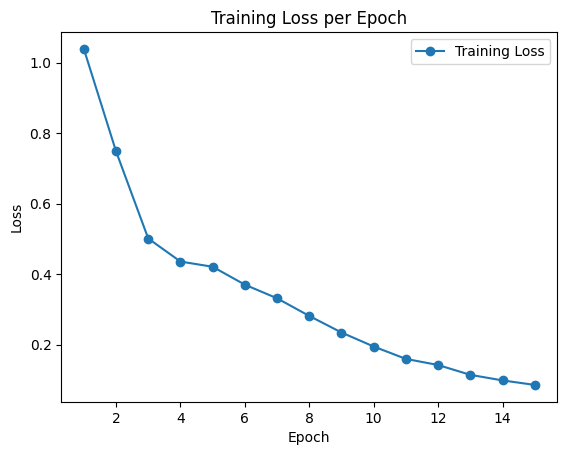

In [15]:

# Running our classifier over the data, saving it to a file in parallel so we can use it for classification later(checkpoint).
# I've plotted Training Loss per Epoch as a performance measure.
# 15 Epochs was chosen by trial and error

model = EMGEEGECG_classifier()

file_path = "EMGEEGECG_classifier.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=0)
callbacks_list = [checkpoint, redonplat]  

model.fit(X_train, Y_train_fix, epochs=15, verbose=1, callbacks=callbacks_list, validation_split=0.1)

f, ax = plt.subplots()
ax.plot([None] + model.history.history['loss'], 'o-')
ax.legend(['Training Loss'], loc = 0)
ax.set_title('Training Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [16]:
# call our model, and calculate f1 score
model.load_weights(file_path)

pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

f1 = f1_score(Y_test_fix, pred_test, average="macro")

print("Test f1 score : %s "% f1)



Test f1 score : 0.9775398196123585 


In [ ]:
# Comments: I believe that with the addition of more layers, the result would get better. However, I've decided to wait until
# I get a better understanding on the principles of neural networks, in the mean time I think this is enough for a proof of concept.